In [1]:
!pip install modisco
!pip install biopython
!pip install dmslogo

from google.colab import output
output.clear()

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from functools import partial
import ast
import dmslogo

import arviz as az
import seaborn as sns
import scipy.cluster.hierarchy as hierarchy
import scipy.sparse as sparse
import scipy.stats as stats

import Bio
from Bio import motifs
from operator import itemgetter
from modisco.visualization import viz_sequence

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)

# from tqdm.auto import tqdm
# tqdm.pandas()
from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
    print('No GPU available')

No GPU available


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','C','G','T']
        self.DNA_COMPLEMENTS = {'A':'T', 'G':'C', 'T':'A', 'C':'G'}
constants = constants()

class utils():   
    @staticmethod
    def pad_pssm(row, pad_len=24, column_name='pssm'):
        padded_pssm = np.zeros((4, pad_len))
        padded_pssm[:, 0:row['length']] = row[column_name]
        return padded_pssm

    @staticmethod
    def pad_seq_tensor(seq_tensor, pad_len=217, dim=-1):
        assert seq_tensor.shape[dim] <= pad_len
        padded_tensor = torch.zeros((4, pad_len))
        padded_tensor[:, 0:seq_tensor.shape[dim]] = seq_tensor
        return padded_tensor
        
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=['A', 'C', 'G', 'T']):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq
    
    @staticmethod
    def reverse_complement_onehot(x, nt_order=constants.STANDARD_NT, 
                              complements=constants.DNA_COMPLEMENTS):
        comp_alphabet = [ complements[nt] for nt in nt_order ]
        permutation = [ nt_order.index(nt) for nt in comp_alphabet ]   
        return torch.flip(x[..., permutation, :], dims=[-1])

    @staticmethod
    def append_zero_tensor(row, in_column_name='seq_tensor', target_len=217):
        seq__tensor = row[in_column_name]
        num_zeros = target_len - seq__tensor.shape[-1]
        zeros = torch.zeros((4, num_zeros))
        padded_seq = torch.cat( (seq__tensor, zeros), dim=-1 )
        return padded_seq

def counts_to_ppm(in_tensor):
    motif = in_tensor.div( in_tensor.sum(0) )
    return motif

def ppm_to_pwm(in_tensor,bkg=[0.25,0.25,0.25,0.25]):
    motif = in_tensor.div(torch.tensor(bkg).unsqueeze(1)).log2()
    return motif

def ppm_to_U(in_tensor):
    return (in_tensor.log2() * in_tensor).sum(0).mul(-1.)

def ppm_to_IC(in_tensor):
    return in_tensor * ppm_to_U( in_tensor ).mul(-1.).add(2.)

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

def single_scatterplot(data_df, x_axis, y_axis, color_axis, fig_size=(15,8), dot_size=0.5, title='',
                       dot_alpha=0.5, style='seaborn-whitegrid', colormap='winter',
                       x_label='Experimental', y_label='Predicted', color_label='l2fc SE', title_font_size=18,
                       title_font_weight='medium', axis_font_size=16):
    with plt.style.context(style):
        fig, ax = plt.subplots()    
        data_df.plot(kind='scatter', x=x_axis, y=y_axis, figsize=fig_size, c=color_axis, ax=ax,
                        alpha=dot_alpha, s=dot_size, colormap=colormap)
        plt.xlabel(x_label, fontsize=axis_font_size)
        plt.ylabel(y_label, fontsize=axis_font_size)

        f = plt.gcf()
        cax = f.get_axes()[1]
        cax.set_ylabel(color_label, fontsize=axis_font_size)

        x_min, y_min = data_df[[x_axis, y_axis]].min().to_numpy() 
        x_max, y_max = data_df[[x_axis, y_axis]].max().to_numpy()
        min_point, max_point = min(x_min, y_min), max(x_max, y_max)
        plt.plot((min_point,max_point), (min_point,max_point), color='black', linestyle='--', alpha=0.5)

        Pearson = round(data_df[[x_axis, y_axis]].corr(method='pearson')[x_axis][1], 2)
        Spearman = round(data_df[[x_axis, y_axis]].corr(method='spearman')[x_axis][1], 2)

        #title = f'{title}  |  Pearson={Pearson}  Spearman={Spearman}'
        title = f'{title}  |  Pearson {Pearson}'
        ax.set_title(title, fontdict={'fontsize': title_font_size, 'fontweight': title_font_weight}, pad=15)
        
        ax.tick_params(axis='both', which='major', labelsize=axis_font_size)

def string_to_numpy(text, dtype=None):
    """
    Convert text into 1D or 2D arrays using np.matrix().
    The result is returned as an np.ndarray.
    """
    import re
    text = text.strip()
    # Using a regexp, decide whether the array is flat or not.
    # The following matches either: "[1 2 3]" or "1 2 3"
    is_flat = bool(re.match(r"^(\[[^\[].+[^\]]\]|[^\[].+[^\]])$",
                            text, flags=re.S))
    # Replace newline characters with semicolons.
    text = text.replace("]\n", "];")
    # Prepare the result.
    result = np.asarray(np.matrix(text, dtype=dtype))
    return result.flatten() if is_flat else result

def str2tensor(array_string):
    return torch.tensor([float(item) for item in array_string.lstrip('[[ ').rstrip(' ]]').split(' ') if item != ''])

def ppm_to_IC_alt(in_tensor):
    U = (in_tensor.log2() * in_tensor).sum(dim=1).mul(-1.)
    return in_tensor * U[:, None, :].mul(-1.).add(2.)

def tensor_to_pandas(in_tensor, tokens=constants.STANDARD_NT, colors=['green','orange','red','blue']):
    data = []
    my_array = in_tensor.cpu().numpy()
    for nt, score_vec,color in zip(tokens,[ sub_a for sub_a in my_array ],colors):
         _ = [ data.append([j,nt,score,color]) for j,score in enumerate(score_vec) ]
    return pd.DataFrame(data=data,columns=['site', 'letter', 'height','color'])

def matrix_to_dms(in_tensor, ax=None, y_max=2, fontaspect=.65, widthscale=0.8,
                  axisfontscale=0.6, heightscale=0.5, colors=['green','orange','red','blue']):
    motif = tensor_to_pandas(in_tensor, colors=colors)
    fig, ax = dmslogo.draw_logo(data=motif,
                                x_col='site',
                                letter_col='letter',
                                letter_height_col='height',
                                color_col='color',
                                ax=ax,
                                fixed_ymax=y_max,
                                fontaspect=fontaspect,
                                widthscale=widthscale,
                                axisfontscale=axisfontscale,
                                heightscale=heightscale)
    return fig, ax

class Score_Motifs(nn.Module):
    def __init__(self, filters, threshold_scores):
        super().__init__()
        self.register_buffer('filters', filters)
        self.register_buffer('threshold_scores', threshold_scores)
        
    def forward(self, x):
        scores = F.conv1d(x, self.filters)
        mask = (scores > self.threshold_scores[None, :, None])
        sequence_idxs, motif_idxs, positions = torch.where(mask == True)
        motif_scores = scores[mask]
        return sequence_idxs, motif_idxs, positions, motif_scores

def get_motif_instances(onehot_sequences, scorer, eval_batch_size=512, half_precision=False):
    temp_dataset = TensorDataset(onehot_sequences)
    temp_dataloader = DataLoader(temp_dataset, batch_size=eval_batch_size)

    all_sequence_idxs = []
    all_motif_idxs = []
    all_motif_positions = []
    all_motif_scores = []
    batch_counter = 0
    for local_batch in tqdm(temp_dataloader):
        #sequence_idxs, motif_idxs, motif_positions, motif_scores = scorer(local_batch[0].cuda())
        sequence_idxs, motif_idxs, motif_positions, motif_scores = scorer(local_batch[0])
        all_sequence_idxs.append(sequence_idxs.cpu() + batch_counter * eval_batch_size)
        all_motif_idxs.append(motif_idxs.cpu())
        all_motif_positions.append(motif_positions.cpu())
        all_motif_scores.append(motif_scores.cpu())
        batch_counter += 1

    all_sequence_idxs = torch.cat(all_sequence_idxs)
    all_motif_idxs = torch.cat(all_motif_idxs)
    all_motif_positions = torch.cat(all_motif_positions)
    all_motif_scores = torch.cat(all_motif_scores)

    if half_precision:
        all_motif_scores = all_motif_scores.type(torch.half)

    return all_sequence_idxs, all_motif_idxs, all_motif_positions, all_motif_scores

### Load TF library

In [4]:
file_path = '/content/drive/MyDrive/data/tf_motifs/HOCOMOCOv11_truly_full_HUMAN_processed_TF_info.txt'

tf_df = pd.read_csv(file_path, sep=' ', low_memory=False)

df_array_columns = ['pfm', 'pwm', 'pwm_rc', 'pssm', 'pssm_rc', 'icm', 'icm_rc', 'padded_pssm', 'padded_pssm_rc']
for df_array_column in tqdm(df_array_columns):
    tf_df[df_array_column] = tf_df.apply(lambda x: string_to_numpy(x[df_array_column]), axis=1)

motif_list = tf_df['name'].tolist()

  0%|          | 0/9 [00:00<?, ?it/s]

### Load sequence library

In [5]:
# --- Load library ---
boda2_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/BODA2_MPRA_results_pred_contributions_v1.txt', sep=" ", low_memory=False)
data_df = boda2_df[boda2_df['method'].notnull()].reset_index(drop=True)

sequence_column_name = 'sequence'
contribution_columns = ['contrib_K562', 'contrib_HepG2', 'contrib_SKNSH']

### Load LDA topics

In [6]:
programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/BODA_topics.txt', sep='\t', header=0, index_col=0)
transformed_programs = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/BODA_transformed_topics.txt', sep='\t', header=0, index_col=0)

motif_weighted_overmax = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/motif_weighted_overmax.txt', sep='\t', header=0, index_col=0).T
motif_ac_id = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/motif_ac_id.txt', sep='\t', index_col=None, header=None)
sequence_annotation = pd.read_table('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/BODA_sequence_topics.txt', sep='\t', header=0, index_col=0)

sequence_annotation = sequence_annotation.reset_index()

### Load FIMO hits

In [7]:
fimo_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/HOCOMOCO_FULL_topics/fimo.tsv', sep='\t')
fimo_df = fimo_df[:-3]

fimo_df['start'] = fimo_df['start'].astype(int) - 1
fimo_df['stop'] = fimo_df['stop'].astype(int)

### Load ENFORMER scores

In [8]:
enformer_scores_df = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/enformer_percentile_analysis.txt', sep='\t')
enformer_scores_df_2 = pd.read_csv('/content/drive/MyDrive/data/BODA2_MPRA/new_enformer_priority.txt', sep='\t')
enformer_scores_df_2 = enformer_scores_df_2[enformer_scores_df_2.columns[:-3]]

### Merge all sequence DFs

In [9]:
enformer_scores_df = enformer_scores_df.rename(columns={'seq_id': 'ID'})
enformer_scores_df_2 = enformer_scores_df_2.rename(columns={'seq_id': 'ID'})
sequence_annotation = sequence_annotation.rename(columns={'id': 'ID'})

seq_merge_df = boda2_df.merge(enformer_scores_df, on='ID')
seq_merge_df = seq_merge_df.merge(enformer_scores_df_2, on='ID')
seq_merge_df = seq_merge_df.merge(sequence_annotation, on='ID')

#--- Drop controls ---
seq_merge_df = seq_merge_df[seq_merge_df['method'].notnull()].reset_index(drop=True)

#--- Select low SEs ---
std_error_cutoff = 0.5
quality_filter = (seq_merge_df[['K562_lfcSE', 'HepG2_lfcSE', 'SKNSH_lfcSE']].max(axis=1) <= std_error_cutoff) 
seq_merge_df = seq_merge_df[quality_filter].reset_index(drop=True)

#--- Additional columns ---
seq_merge_df['HepG2_OverMax'] = seq_merge_df['HepG2_signal'] - seq_merge_df[['K562_signal', 'SKNSH_signal']].max(axis=1)
seq_merge_df['SKNSH_OverMax'] = seq_merge_df['SKNSH_signal'] - seq_merge_df[['K562_signal', 'HepG2_signal']].max(axis=1)

program_columns = [str(i) for i in range(18)]
seq_merge_df['hot_topic'] = seq_merge_df.loc[:, program_columns].idxmax(axis=1).astype(int)

temp_topic_array = seq_merge_df[program_columns].to_numpy()

topic_overmaxs = []
for i in range(18):
    topic_idxs = list(range(18))
    topic_idxs.remove(i)
    topic_overmaxs.append(temp_topic_array[:, i] - temp_topic_array[:, topic_idxs].max(axis=-1))
topic_overmaxs = np.stack(topic_overmaxs).T
topic_overmaxs[topic_overmaxs < 0] = 0

seq_merge_df['topic_OverMax'] = topic_overmaxs.sum(axis=1)

### Parse contributions

In [10]:
onehot_sequences = torch.stack([utils.dna2tensor(seq) for seq in tqdm(seq_merge_df[sequence_column_name].tolist())])

contribution_tensor = []
for contribution_column in tqdm(contribution_columns):
    flat_contributions = torch.stack([str2tensor(contributions).repeat(4,1) \
                                      for contributions in seq_merge_df[contribution_column]])
    contribution_tensor.append(flat_contributions * onehot_sequences)

contribution_tensor = torch.stack(contribution_tensor)

  0%|          | 0/94000 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

# EXPLORATION

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:625: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


<Figure size 864x720 with 0 Axes>

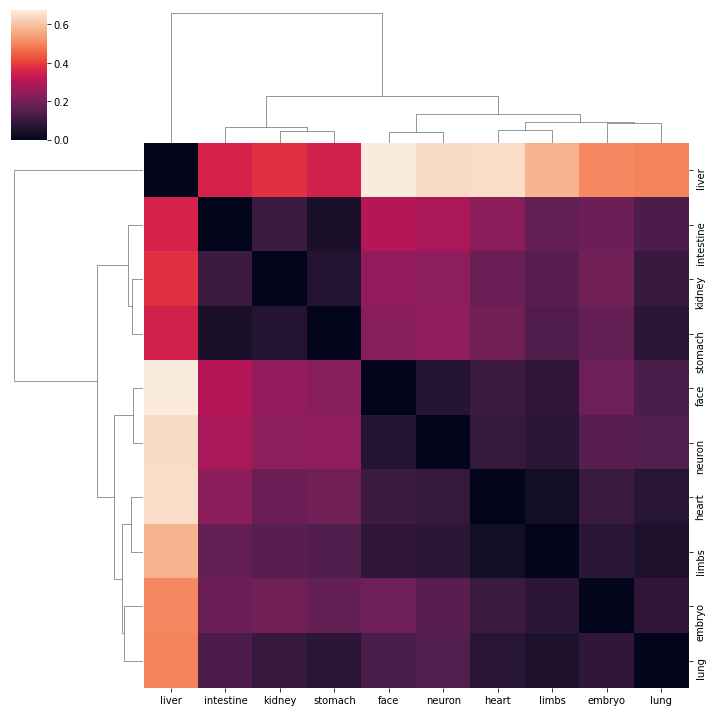

In [11]:
plt.figure(figsize=(12, 10))
sns.clustermap(1 - seq_merge_df[enformer_scores_df_2.columns[1:]].corr())
plt.show()

In [12]:
column_to_overmax = 'liver'
offset_column_list = list(enformer_scores_df_2.columns[1:])
offset_column_list.remove(column_to_overmax)
seq_merge_df[f'{column_to_overmax}_OverMax'] = seq_merge_df[column_to_overmax] - seq_merge_df[offset_column_list].max(axis=1)

In [13]:
column_to_overmax = 'neuron'
offset_column_list = list(enformer_scores_df_2.columns[1:])
offset_column_list.remove(column_to_overmax)
seq_merge_df[f'{column_to_overmax}_OverMax'] = seq_merge_df[column_to_overmax] - seq_merge_df[offset_column_list].max(axis=1)

In [14]:
seq_merge_df['neuron_over_liver_2'] = seq_merge_df['neuron'] - seq_merge_df['liver']

In [15]:
faceless_list = list(enformer_scores_df_2.columns[1:-2])
faceless_list.remove('face')

seq_merge_df['neuron_over_liver_OverMax'] = seq_merge_df['neuron'] - seq_merge_df['liver'] - seq_merge_df[faceless_list].mean(axis=1)

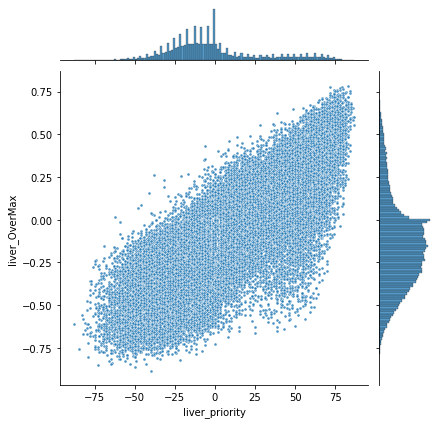

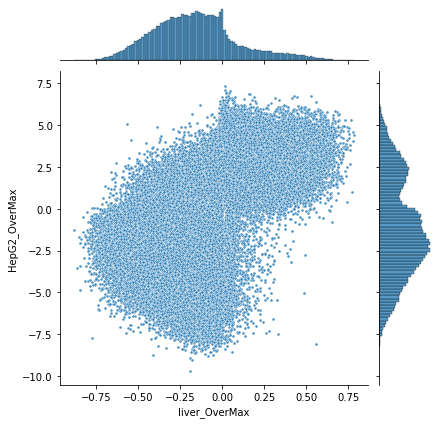

In [16]:
sns.jointplot(data=seq_merge_df, x='liver_priority', y='liver_OverMax', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='liver_OverMax', y='HepG2_OverMax', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

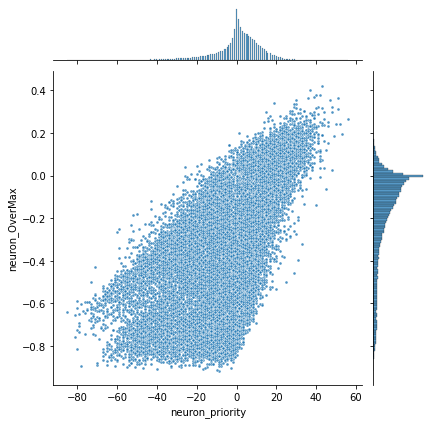

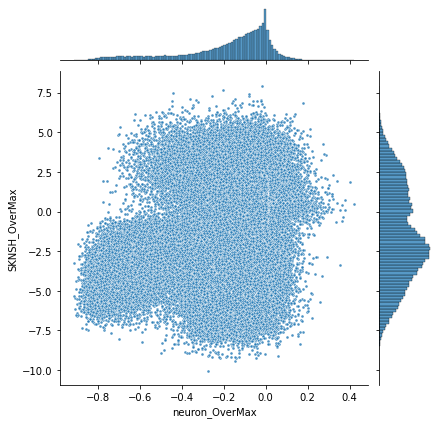

In [17]:
sns.jointplot(data=seq_merge_df, x='neuron_priority', y='neuron_OverMax', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='neuron_OverMax', y='SKNSH_OverMax', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

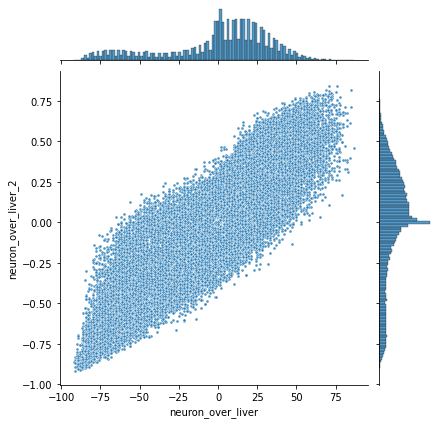

In [18]:
sns.jointplot(data=seq_merge_df, x='neuron_over_liver', y='neuron_over_liver_2', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

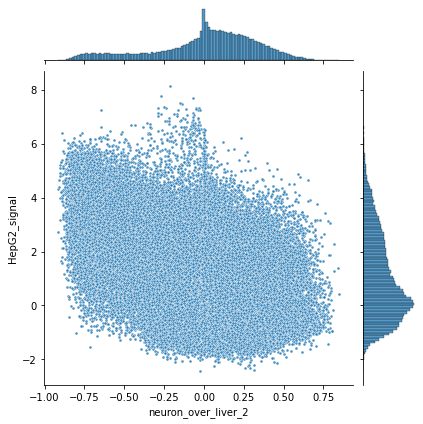

In [19]:
sns.jointplot(data=seq_merge_df, x='neuron_over_liver_2', y='HepG2_signal', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

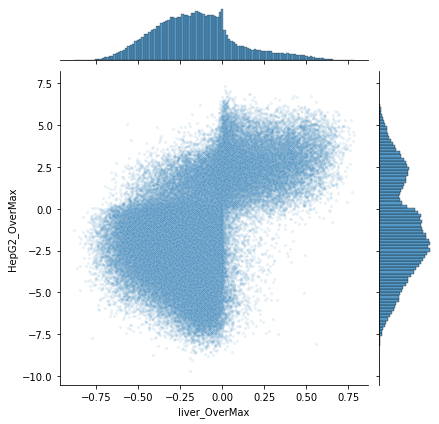

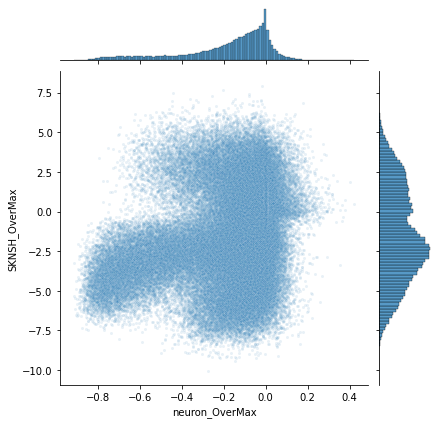

In [28]:
sns.jointplot(data=seq_merge_df, x='liver_OverMax', y='HepG2_OverMax', joint_kws={'alpha': 0.1, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='neuron_OverMax', y='SKNSH_OverMax', joint_kws={'alpha': 0.1, 'marker':'.'})
plt.show()

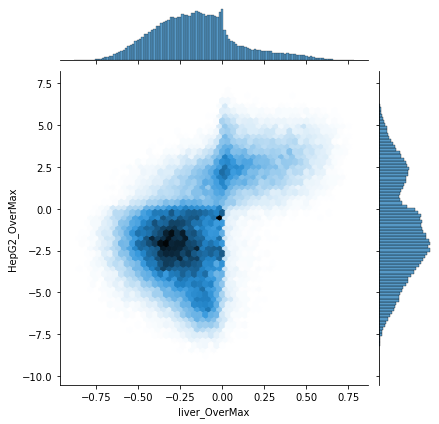

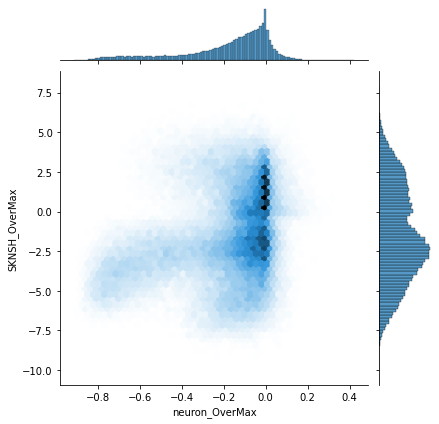

In [27]:
sns.jointplot(data=seq_merge_df, x='liver_OverMax', y='HepG2_OverMax', kind='hex')#joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='neuron_OverMax', y='SKNSH_OverMax', kind='hex')#joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

In [22]:
print(seq_merge_df['liver_OverMax'].corr(seq_merge_df['HepG2_OverMax']))
print(seq_merge_df['neuron_OverMax'].corr(seq_merge_df['SKNSH_OverMax']))

0.5016230931309428
0.2545523821133944


### Removing FACE for liver_OverMax

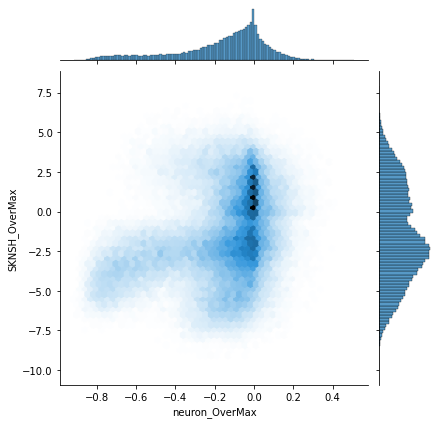

0.27206551583610067


In [32]:
# column_to_overmax = 'neuron'
# offset_column_list = list(enformer_scores_df_2.columns[1:])
# offset_column_list.remove(column_to_overmax)
# offset_column_list.remove('face')
# seq_merge_df[f'{column_to_overmax}_OverMax'] = seq_merge_df[column_to_overmax] - seq_merge_df[offset_column_list].max(axis=1)

# sns.jointplot(data=seq_merge_df, x='neuron_OverMax', y='SKNSH_OverMax', kind='hex')#joint_kws={'alpha': 0.8, 'marker':'.'})
# plt.show()
# print(seq_merge_df['neuron_OverMax'].corr(seq_merge_df['SKNSH_OverMax']))

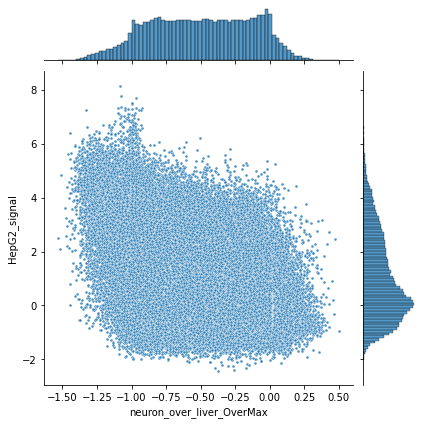

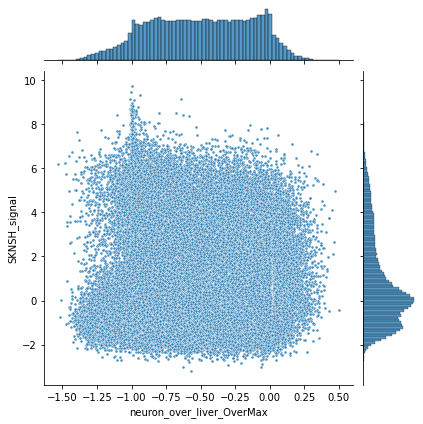

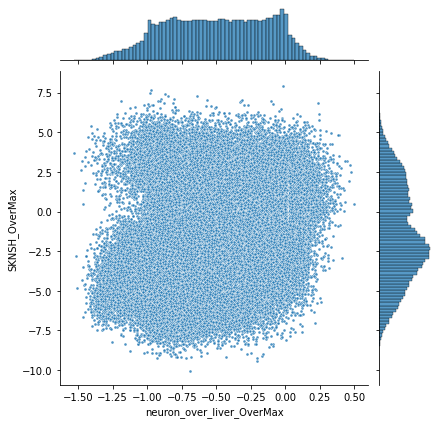

In [ ]:
sns.jointplot(data=seq_merge_df, x='neuron_over_liver_OverMax', y='HepG2_signal', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='neuron_over_liver_OverMax', y='SKNSH_signal', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

sns.jointplot(data=seq_merge_df, x='neuron_over_liver_OverMax', y='SKNSH_OverMax', joint_kws={'alpha': 0.8, 'marker':'.'})
plt.show()

### Vizualize top sequences

310


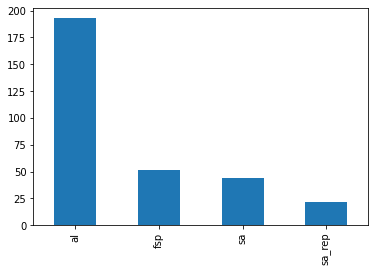

In [ ]:
filter_condition = (seq_merge_df['neuron_over_liver_OverMax'] >= 0) & (seq_merge_df['HepG2_signal'] < 0) & (seq_merge_df['SKNSH_OverMax'] >= 3.0) & (seq_merge_df['K562_signal'] < 0)
sorting_column = 'neuron_over_liver_OverMax'

temp_df = seq_merge_df[filter_condition].sort_values(sorting_column, ascending=False).reset_index(drop=True)
print(len(temp_df))

temp_df['method'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

0  20211212_75659__621411__391::fsp__sknsh__0  |  K562 l2FC = -0.87,  HepG2 l2FC = -0.31,  SKNSH l2FC = 4.52  | (Topic 1 OverMax = 0.03)


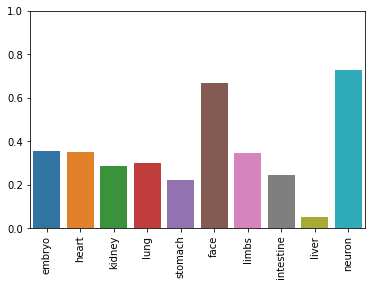


1  20211212_82245__817810__188::fsp__sknsh__0  |  K562 l2FC = -0.6,  HepG2 l2FC = -0.42,  SKNSH l2FC = 2.71  | (Topic 2 OverMax = 0.28)


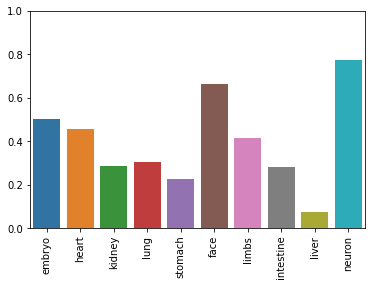


2  20211212_14909__942569__791::fsp__sknsh__0  |  K562 l2FC = -0.83,  HepG2 l2FC = -0.03,  SKNSH l2FC = 3.28  | (Topic 2 OverMax = 0.37)


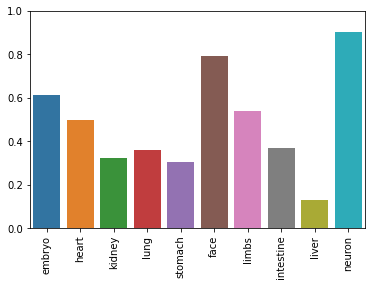


3  20211212_73316__958155__233::fsp__sknsh__0  |  K562 l2FC = -0.76,  HepG2 l2FC = -0.51,  SKNSH l2FC = 2.8  | (Topic 0 OverMax = 0.19)


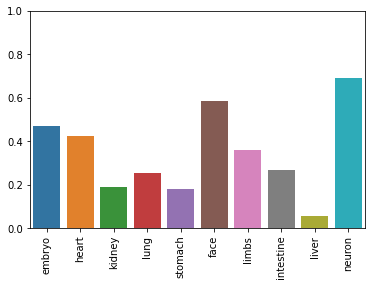


4  20211207_212124__46481152__3727::al__sknsh__0  |  K562 l2FC = -0.57,  HepG2 l2FC = -0.87,  SKNSH l2FC = 3.68  | (Topic 14 OverMax = 0.57)


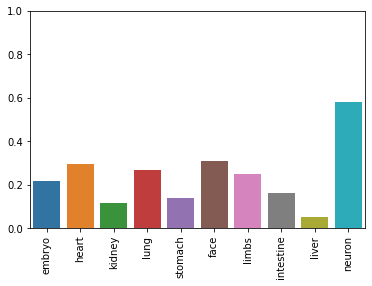


5  20211207_212124__46481152__41::al__sknsh__0  |  K562 l2FC = -0.95,  HepG2 l2FC = -0.96,  SKNSH l2FC = 2.28  | (Topic 8 OverMax = 0.1)


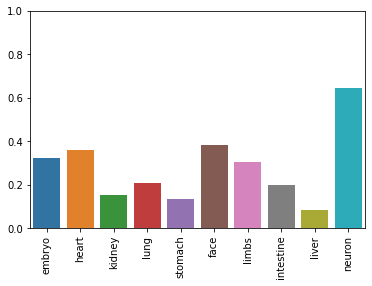


6  20211207_212124__46481152__1179::al__sknsh__0  |  K562 l2FC = -0.56,  HepG2 l2FC = -0.58,  SKNSH l2FC = 3.45  | (Topic 8 OverMax = 0.76)


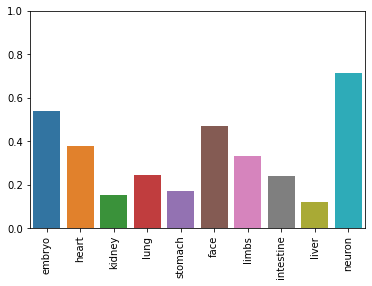


7  20211212_122659__199840__137::fsp__sknsh__0  |  K562 l2FC = -0.43,  HepG2 l2FC = -0.14,  SKNSH l2FC = 3.6  | (Topic 5 OverMax = 0.24)


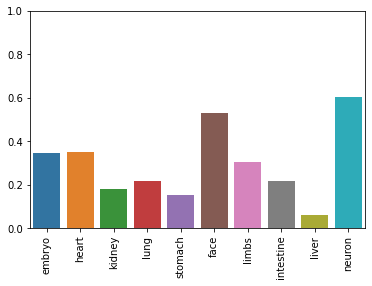


8  20211207_212124__46481152__1598::al__sknsh__0  |  K562 l2FC = -1.39,  HepG2 l2FC = -0.42,  SKNSH l2FC = 4.63  | (Topic 8 OverMax = 0.16)


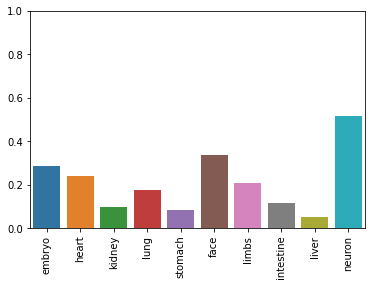


9  20211212_14909__942569__452::fsp__sknsh__0  |  K562 l2FC = -0.39,  HepG2 l2FC = -0.36,  SKNSH l2FC = 2.74  | (Topic 8 OverMax = 0.29)


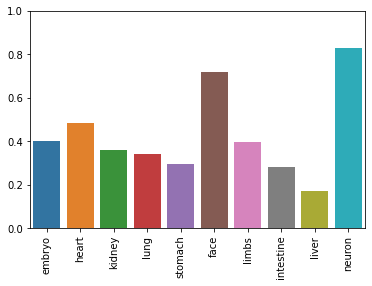


10  20211207_175000__383007__1814::sa__sknsh__0  |  K562 l2FC = -0.54,  HepG2 l2FC = -0.33,  SKNSH l2FC = 3.18  | (Topic 8 OverMax = 0.4)


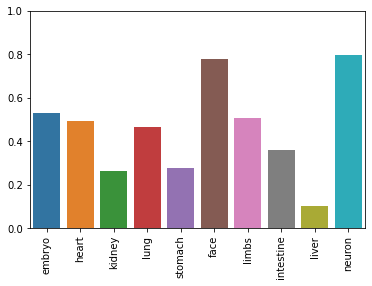


11  20211207_212124__46481152__3990::al__sknsh__0  |  K562 l2FC = -0.48,  HepG2 l2FC = -0.02,  SKNSH l2FC = 3.79  | (Topic 6 OverMax = 0.03)


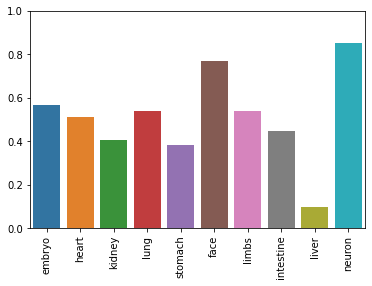


12  20211214_111905__704605__1151::sa_rep__sknsh__0  |  K562 l2FC = -0.77,  HepG2 l2FC = -0.47,  SKNSH l2FC = 2.87  | (Topic 8 OverMax = 0.23)


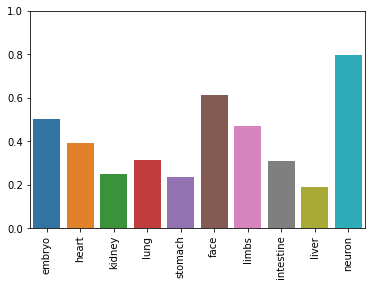


13  20211207_212124__46481152__3701::al__sknsh__0  |  K562 l2FC = -0.34,  HepG2 l2FC = -0.17,  SKNSH l2FC = 3.23  | (Topic 9 OverMax = 0.17)


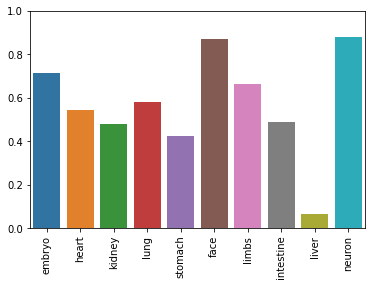


14  20211207_212124__46481152__2574::al__sknsh__0  |  K562 l2FC = -0.99,  HepG2 l2FC = -0.66,  SKNSH l2FC = 2.74  | (Topic 4 OverMax = 0.07)


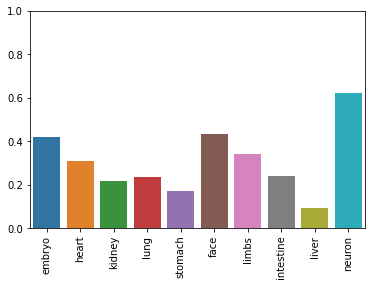


15  20211207_212124__46481152__1162::al__sknsh__0  |  K562 l2FC = -0.58,  HepG2 l2FC = -0.53,  SKNSH l2FC = 4.29  | (Topic 8 OverMax = 0.07)


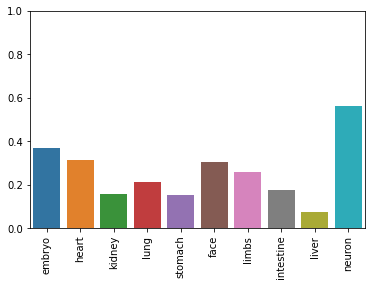


16  20211207_212124__46481152__3716::al__sknsh__0  |  K562 l2FC = -0.95,  HepG2 l2FC = -0.15,  SKNSH l2FC = 4.4  | (Topic 8 OverMax = 0.1)


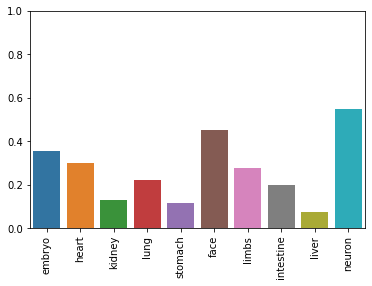


17  20211207_212124__46481152__3733::al__sknsh__0  |  K562 l2FC = -0.01,  HepG2 l2FC = -0.05,  SKNSH l2FC = 4.01  | (Topic 8 OverMax = 0.19)


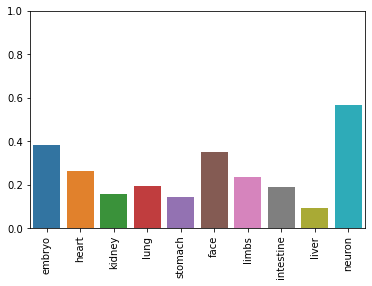


18  20211207_212124__46481152__2074::al__sknsh__0  |  K562 l2FC = -0.24,  HepG2 l2FC = -0.04,  SKNSH l2FC = 3.89  | (Topic 9 OverMax = 0.03)


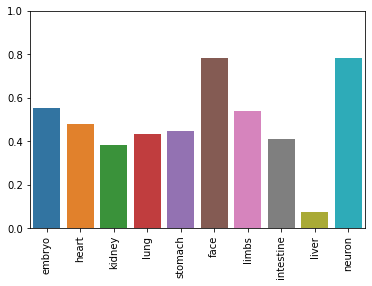


19  20211207_212124__46481152__618::al__sknsh__0  |  K562 l2FC = -0.45,  HepG2 l2FC = -0.94,  SKNSH l2FC = 2.87  | (Topic 8 OverMax = 0.22)


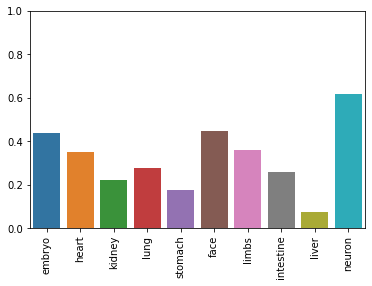


20  20211207_212124__46481152__3404::al__sknsh__0  |  K562 l2FC = -1.01,  HepG2 l2FC = -1.11,  SKNSH l2FC = 5.14  | (Topic 2 OverMax = 0.18)


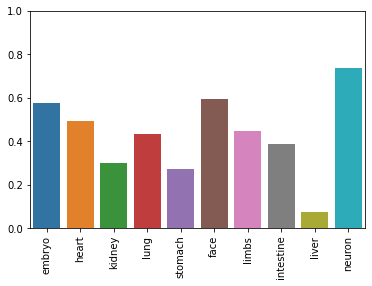


21  20211207_212124__46481152__275::al__sknsh__0  |  K562 l2FC = -0.61,  HepG2 l2FC = -0.05,  SKNSH l2FC = 4.28  | (Topic 10 OverMax = 0.11)


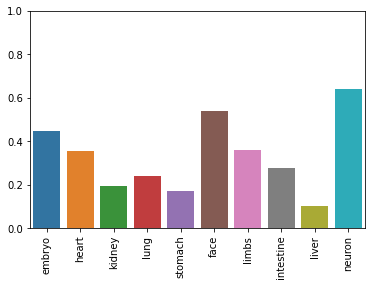


22  20211212_14909__942569__1739::fsp__sknsh__0  |  K562 l2FC = -0.45,  HepG2 l2FC = -0.68,  SKNSH l2FC = 5.35  | (Topic 2 OverMax = 0.32)


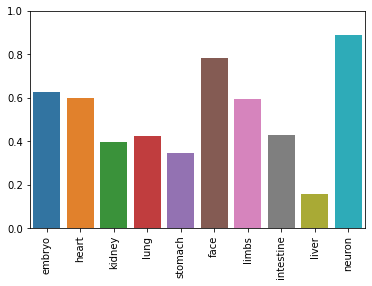


23  20211207_152258__777391__191::sa__sknsh__0  |  K562 l2FC = -0.43,  HepG2 l2FC = -0.11,  SKNSH l2FC = 3.62  | (Topic 11 OverMax = 0.51)


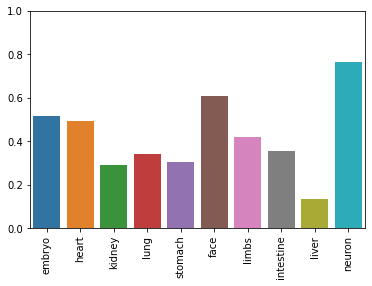


24  20211207_212124__46481152__2636::al__sknsh__0  |  K562 l2FC = -0.79,  HepG2 l2FC = -0.92,  SKNSH l2FC = 6.03  | (Topic 8 OverMax = 0.19)


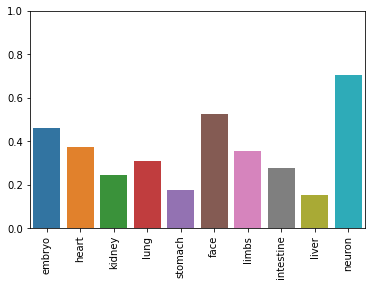


25  20211207_212124__46481152__29::al__sknsh__0  |  K562 l2FC = -0.36,  HepG2 l2FC = -0.97,  SKNSH l2FC = 3.21  | (Topic 8 OverMax = 0.11)


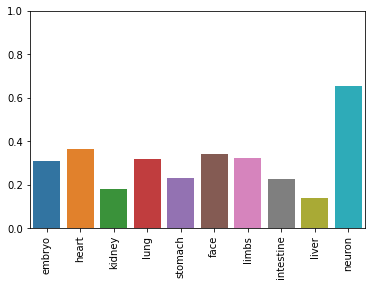


26  20211212_75659__621411__1158::fsp__sknsh__3  |  K562 l2FC = -0.95,  HepG2 l2FC = -0.51,  SKNSH l2FC = 2.52  | (Topic 6 OverMax = 0.13)


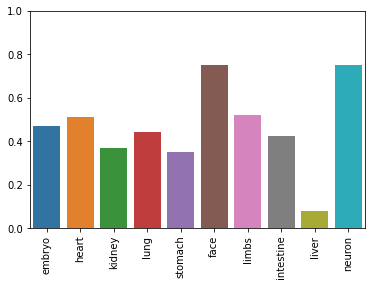


27  20211207_212124__46481152__1439::al__sknsh__0  |  K562 l2FC = -0.56,  HepG2 l2FC = -0.4,  SKNSH l2FC = 2.94  | (Topic 2 OverMax = 0.06)


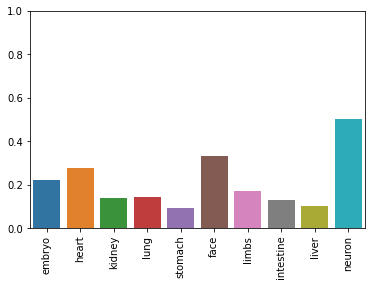


28  20211207_152258__777391__201::sa__sknsh__0  |  K562 l2FC = -0.09,  HepG2 l2FC = -0.12,  SKNSH l2FC = 4.04  | (Topic 14 OverMax = 0.04)


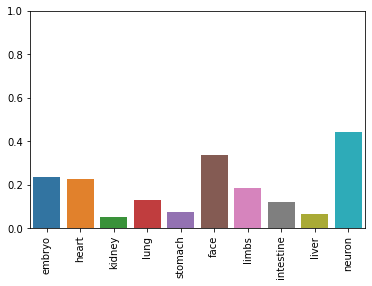


29  20211207_212124__46481152__2129::al__sknsh__0  |  K562 l2FC = -0.58,  HepG2 l2FC = -0.35,  SKNSH l2FC = 3.71  | (Topic 2 OverMax = 0.19)


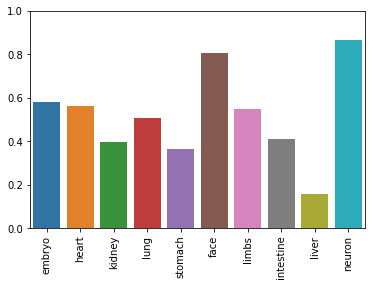


30  20211212_14909__942569__1175::fsp__sknsh__0  |  K562 l2FC = -0.2,  HepG2 l2FC = -0.37,  SKNSH l2FC = 2.96  | (Topic 2 OverMax = 0.12)


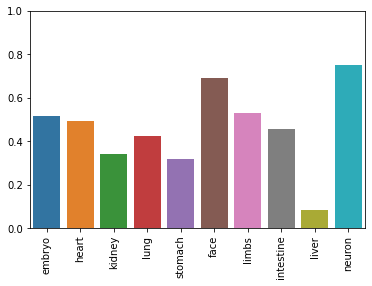


31  20211212_14909__942569__688::fsp__sknsh__0  |  K562 l2FC = -0.68,  HepG2 l2FC = -0.22,  SKNSH l2FC = 3.91  | (Topic 6 OverMax = 0.25)


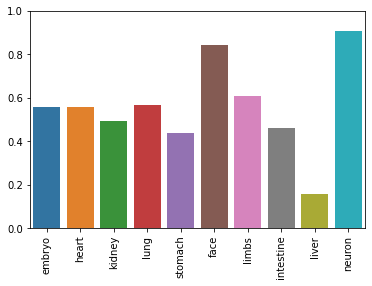


32  20211207_212124__46481152__1097::al__sknsh__0  |  K562 l2FC = -0.69,  HepG2 l2FC = -0.4,  SKNSH l2FC = 2.93  | (Topic 13 OverMax = 0.04)


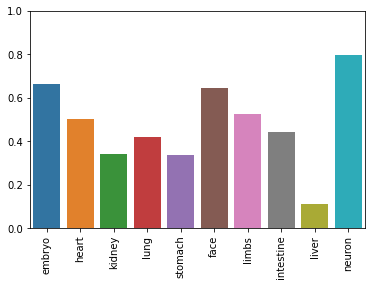


33  20211212_122659__199840__199::fsp__sknsh__0  |  K562 l2FC = -0.53,  HepG2 l2FC = -0.27,  SKNSH l2FC = 3.05  | (Topic 8 OverMax = 0.41)


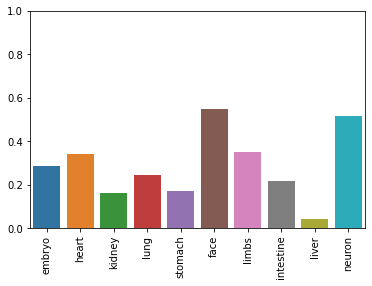


34  20211207_212124__46481152__3095::al__sknsh__0  |  K562 l2FC = -0.82,  HepG2 l2FC = -1.21,  SKNSH l2FC = 2.89  | (Topic 8 OverMax = 0.77)


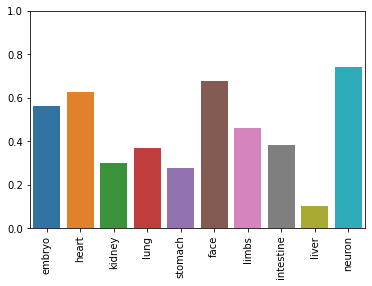


35  20211207_212124__46481152__2927::al__sknsh__0  |  K562 l2FC = -0.36,  HepG2 l2FC = -0.23,  SKNSH l2FC = 2.86  | (Topic 8 OverMax = 0.06)


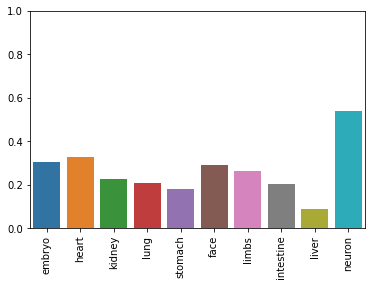


36  20211207_212124__46481152__864::al__sknsh__0  |  K562 l2FC = -0.6,  HepG2 l2FC = -0.02,  SKNSH l2FC = 3.59  | (Topic 6 OverMax = 0.05)


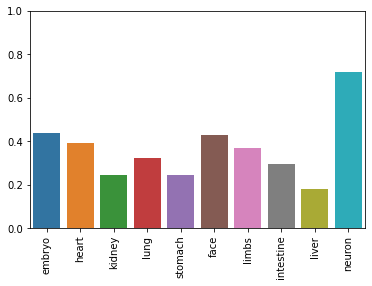


37  20211207_212124__46481152__489::al__sknsh__0  |  K562 l2FC = -0.74,  HepG2 l2FC = -0.91,  SKNSH l2FC = 2.76  | (Topic 8 OverMax = 0.15)


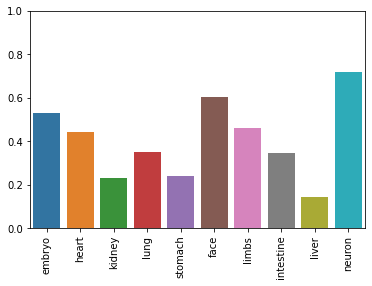


38  20211207_212124__46481152__1720::al__sknsh__0  |  K562 l2FC = -0.68,  HepG2 l2FC = -0.75,  SKNSH l2FC = 2.75  | (Topic 8 OverMax = 0.25)


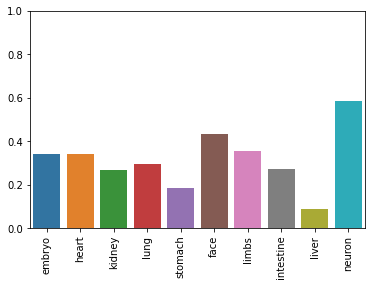


39  20211212_122659__199840__298::fsp__sknsh__0  |  K562 l2FC = -0.45,  HepG2 l2FC = -0.1,  SKNSH l2FC = 3.78  | (Topic 6 OverMax = 0.12)


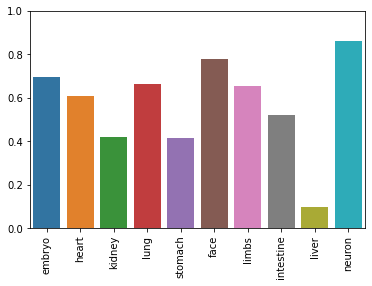

In [ ]:
top_num = 40
for row in temp_df.iloc[:top_num].iterrows():
    seq_df = row[1]

    seq_id = seq_df['ID']
    k562_lfc = np.round(seq_df['K562_signal'], 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'], 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'], 2)
    main_topic = seq_df['hot_topic']
    topic_overmax = np.round(seq_df['topic_OverMax'], 2)

    print(f'{row[0]}  {seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}  | (Topic {main_topic} OverMax = {topic_overmax})')

    sns.barplot(data=pd.DataFrame(seq_df[enformer_scores_df_2.columns[1:]]).T).set(ylim=(0,1))
    plt.xticks(rotation=90)
    plt.show()
    print('')

In [ ]:
idxs_to_see =[0, 1, 3, 4, 6, 7, 15, 20, 22, 23, 24, 31, 33, 35]
seq_ids = [temp_df.iloc[i]['ID'] for i in idxs_to_see]
print(seq_ids)

['20211212_75659__621411__391::fsp__sknsh__0', '20211212_82245__817810__188::fsp__sknsh__0', '20211212_73316__958155__233::fsp__sknsh__0', '20211207_212124__46481152__3727::al__sknsh__0', '20211207_212124__46481152__1179::al__sknsh__0', '20211212_122659__199840__137::fsp__sknsh__0', '20211207_212124__46481152__1162::al__sknsh__0', '20211207_212124__46481152__3404::al__sknsh__0', '20211212_14909__942569__1739::fsp__sknsh__0', '20211207_152258__777391__191::sa__sknsh__0', '20211207_212124__46481152__2636::al__sknsh__0', '20211212_14909__942569__688::fsp__sknsh__0', '20211212_122659__199840__199::fsp__sknsh__0', '20211207_212124__46481152__2927::al__sknsh__0']


In [ ]:
seq_ids = list(set(['20211207_212124__46481152__3404::al__sknsh__0',
           ] + seq_ids))


# topic_idx = 8
# num_seqs_to_display = 10
# seq_idxs = np.where(over_means[:, topic_idx] > 0)[0]
# seq_ids = temp_df.iloc[seq_idxs]['ID'].tolist()
# topic_overmaxs = over_means[seq_idxs, topic_idx]
# idxs_to_display = np.flip(np.argsort(topic_overmaxs))[:num_seqs_to_display]
# seq_ids = [seq_ids[i] for i in idxs_to_display]

intersection_threshold = 3
cmap = plt.cm.get_cmap('rainbow', len(motif_list)) 

color_dict = dict(zip(2*motif_list, 2*[cmap(i) for i in range(len(motif_list))]))

for order_idx, seq_id in enumerate(seq_ids):
#for order_idx, seq_id in zip(idxs_to_display, seq_ids):
    seq_df = seq_merge_df[seq_merge_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    main_topic = seq_df['hot_topic'].item()
    topic_overmax = np.round(seq_df['topic_OverMax'].item(), 2)
    # hot_topics[order_idx]
    # topic_overmax = np.round(topic_overmaxs[order_idx], 2)
    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}  | (Topic {main_topic} OverMax = {topic_overmax})')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = contribution_tensor[:, seq_idx, ...]
    y_max = seq_contributions.max()

    
    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name.split('_')[0] + '.' + name.split('_')[1].split('.')[2] + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=0.8, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            color = color_dict[motif_name]
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0] 
            y = contrib_min_maxs[idx][1] + 0.05  
            plt.text(x, y, text, fontsize=16)  
        plt.show()  

    sns.barplot(data=pd.DataFrame(seq_df[enformer_scores_df_2.columns[1:]])).set(ylim=(0,1))
    plt.xticks(rotation=90)
    plt.title(seq_id)
    plt.show()

    print('')

Output hidden; open in https://colab.research.google.com to view.

20211207_100944__255626__132::sa__hepg2__0  |  K562 l2FC = -0.69,  HepG2 l2FC = 6.03,  SKNSH l2FC = -1.09  | (Topic 14 OverMax = 0.07)


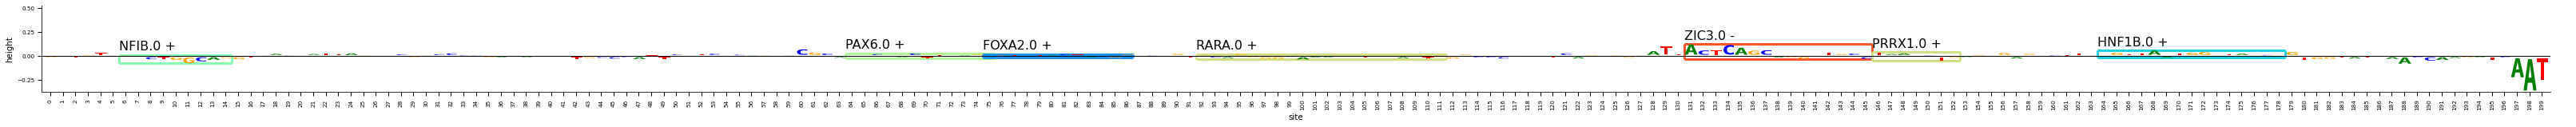

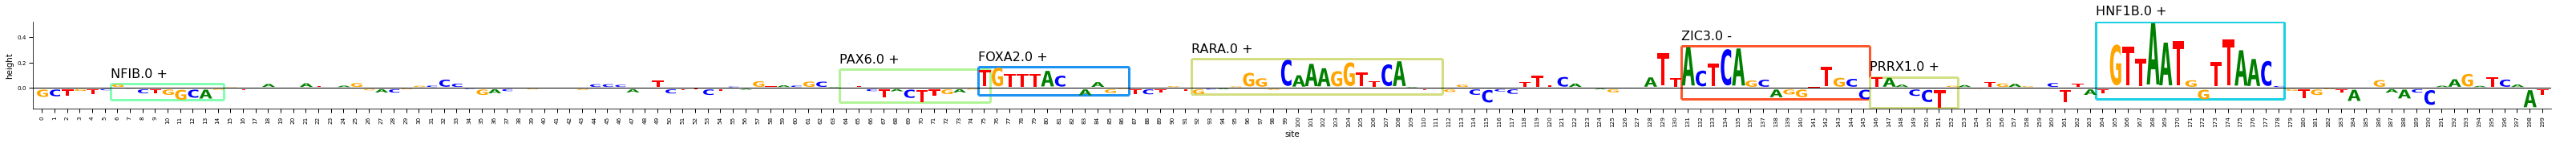

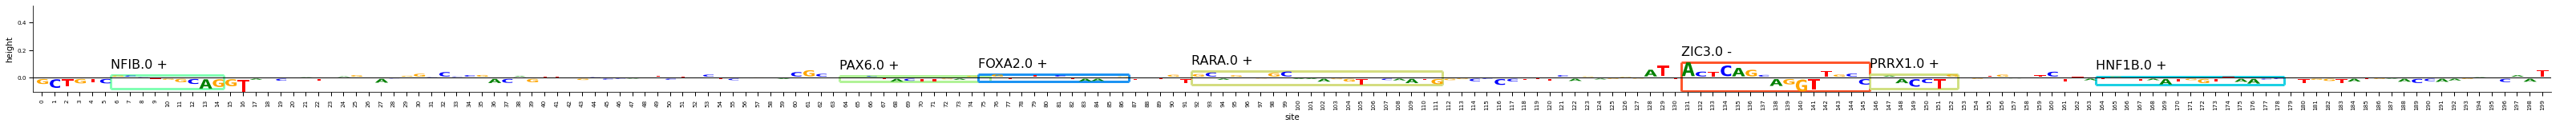

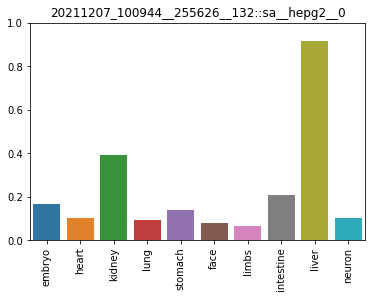


20211206_24503__33072627__1816::al__hepg2__0  |  K562 l2FC = -1.27,  HepG2 l2FC = 4.5,  SKNSH l2FC = -1.62  | (Topic 12 OverMax = 0.04)


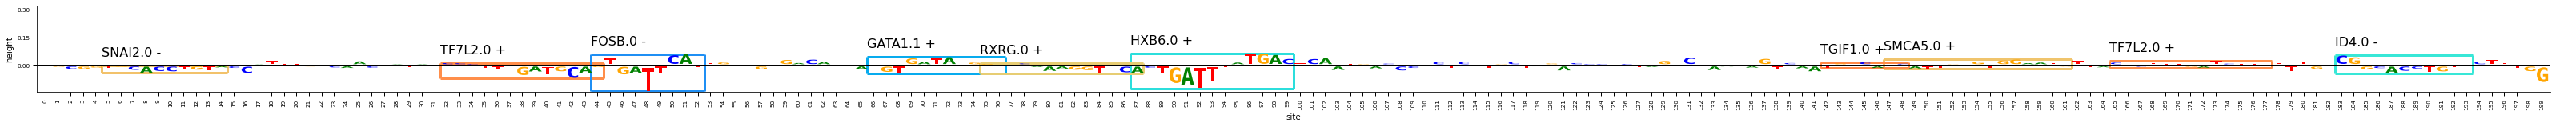

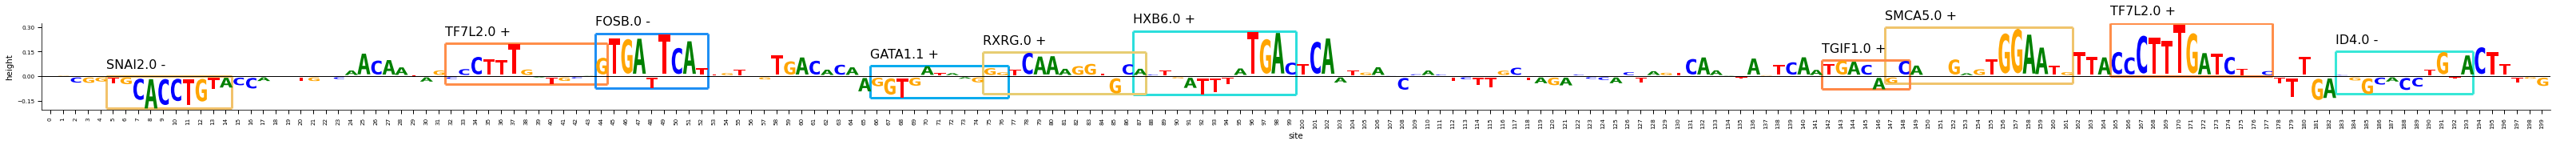

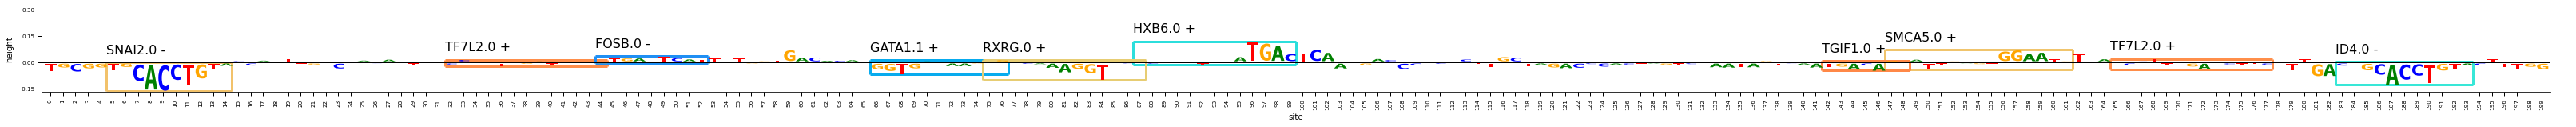

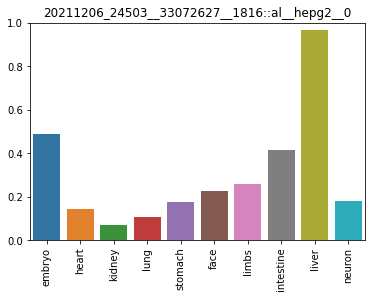

In [ ]:
seq_ids = ['20211207_100944__255626__132::sa__hepg2__0',
           '20211206_24503__33072627__1816::al__hepg2__0']

intersection_threshold = 3
cmap = plt.cm.get_cmap('rainbow', len(motif_list)) 

color_dict = dict(zip(2*motif_list, 2*[cmap(i) for i in range(len(motif_list))]))

for order_idx, seq_id in enumerate(seq_ids):
#for order_idx, seq_id in zip(idxs_to_display, seq_ids):
    seq_df = seq_merge_df[seq_merge_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    main_topic = seq_df['hot_topic'].item()
    topic_overmax = np.round(seq_df['topic_OverMax'].item(), 2)
    # hot_topics[order_idx]
    # topic_overmax = np.round(topic_overmaxs[order_idx], 2)
    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}  | (Topic {main_topic} OverMax = {topic_overmax})')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = contribution_tensor[:, seq_idx, ...]
    y_max = seq_contributions.max()

    
    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name.split('_')[0] + '.' + name.split('_')[1].split('.')[2] + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=0.8, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            color = color_dict[motif_name]
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0] 
            y = contrib_min_maxs[idx][1] + 0.05  
            plt.text(x, y, text, fontsize=16)  
        plt.show()  

    sns.barplot(data=pd.DataFrame(seq_df[enformer_scores_df_2.columns[1:]])).set(ylim=(0,1))
    plt.xticks(rotation=90)
    plt.title(seq_id)
    plt.show()

    print('')

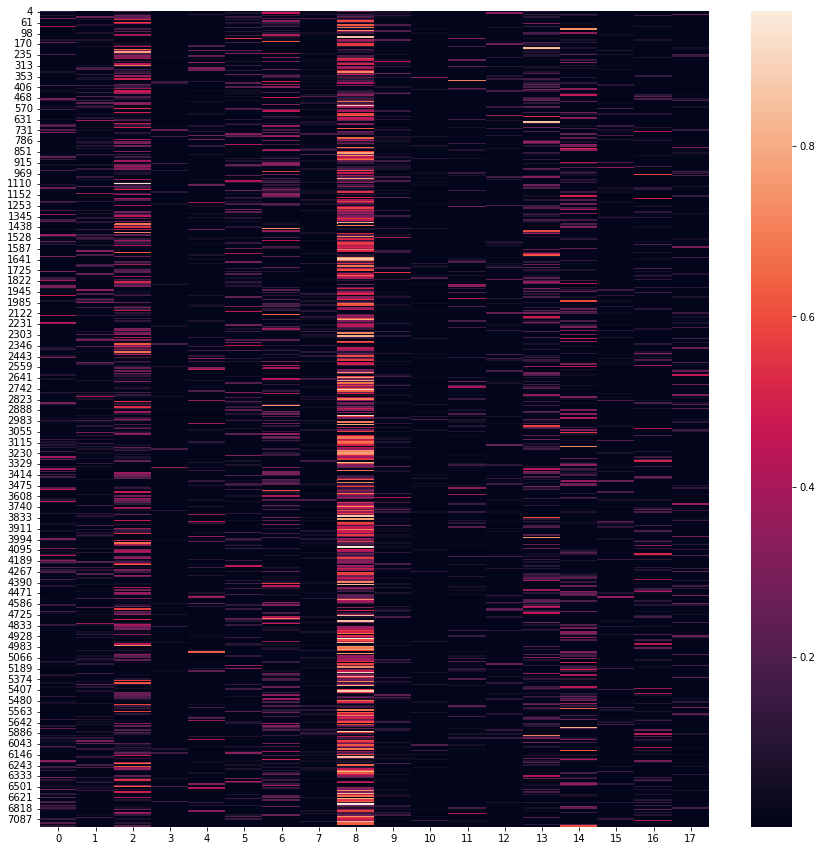

In [ ]:
program_columns = [str(i) for i in range(18)]
plt.figure(figsize=(15,15))
sns.heatmap(temp_df[program_columns])
plt.show()

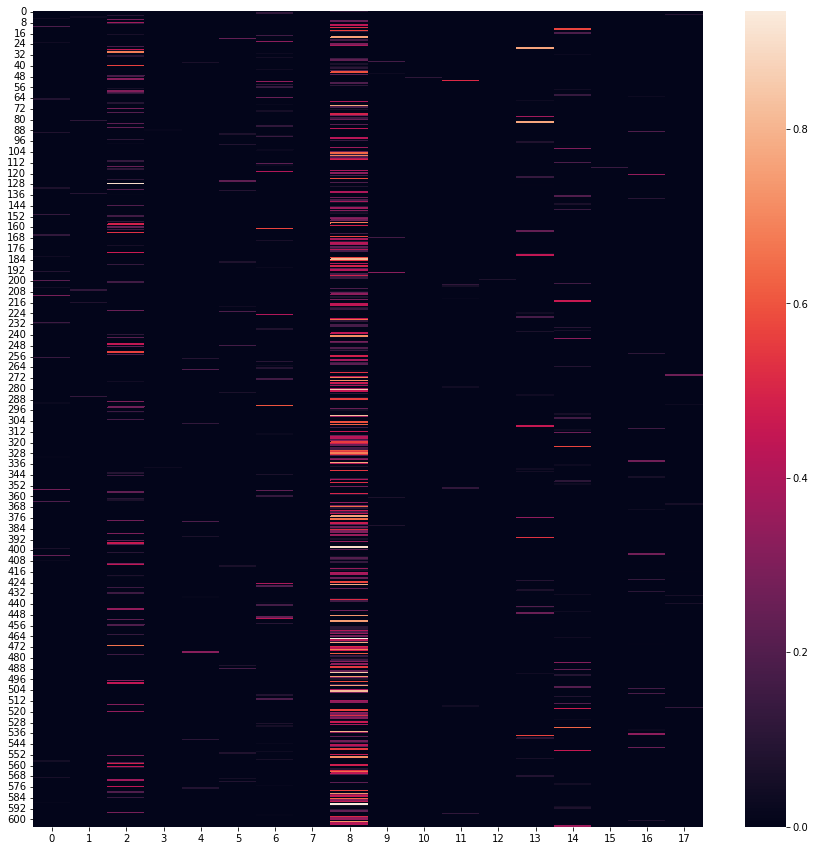

In [ ]:
temp_topic_array = temp_df[program_columns].to_numpy()

over_means = []
for i in range(18):
    topic_idxs = list(range(18))
    topic_idxs.remove(i)
    over_means.append(temp_topic_array[:, i] - temp_topic_array[:, topic_idxs].max(axis=-1))
over_means = np.stack(over_means).T
over_means[over_means < 0] = 0

plt.figure(figsize=(15,15))
sns.heatmap(over_means)
plt.show()

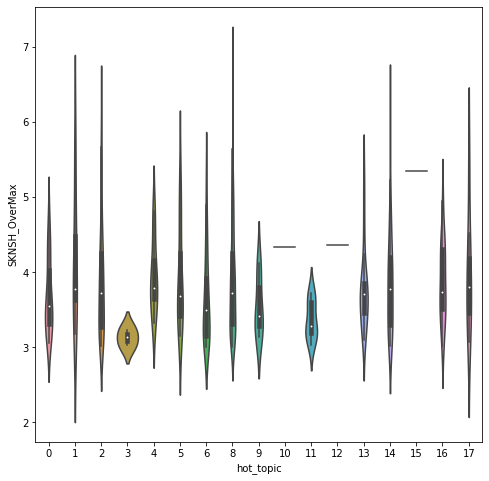

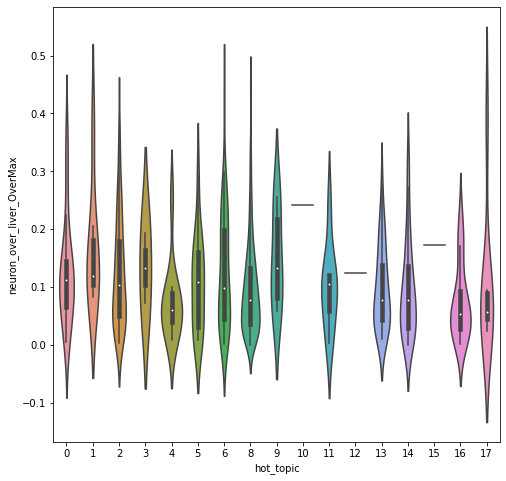

In [ ]:
plt.figure(figsize=(8, 8))
sns.violinplot(data=temp_df, x='hot_topic', y='SKNSH_OverMax')
plt.show()

plt.figure(figsize=(8, 8))
sns.violinplot(data=temp_df, x='hot_topic', y='neuron_over_liver_OverMax')
plt.show()

20211212_122659__199840__1368::fsp__sknsh__4  |  K562 l2FC = -0.59,  HepG2 l2FC = 0.12,  SKNSH l2FC = 3.4  | (Topic 8 OverMax = 5164.24)


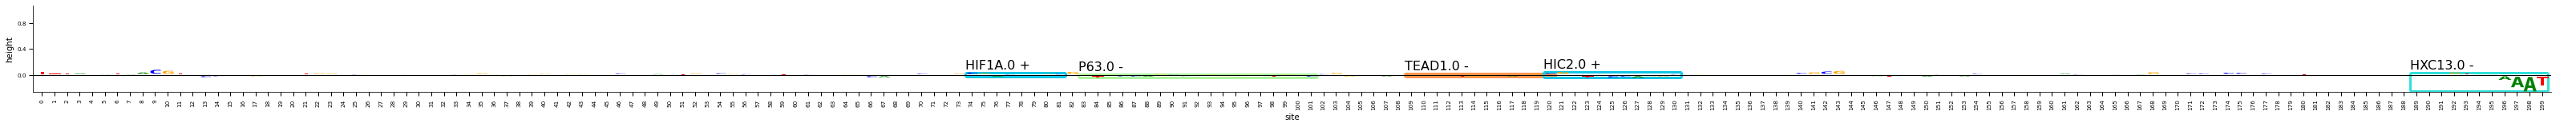

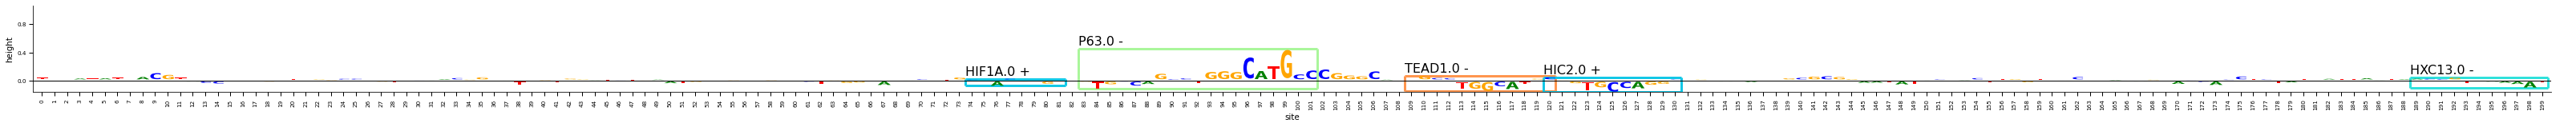

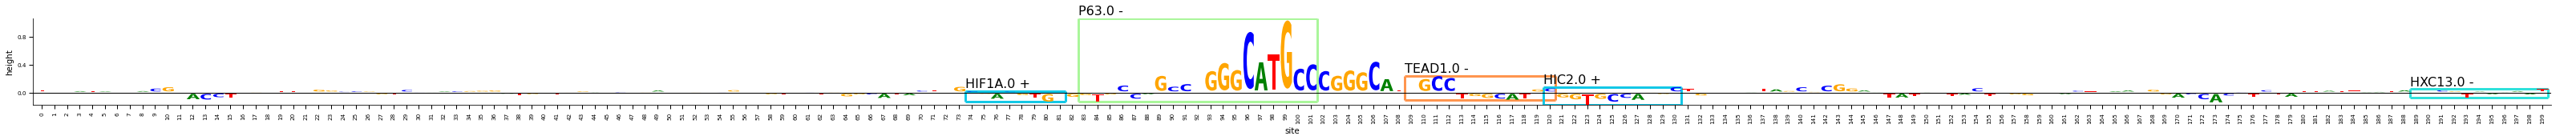

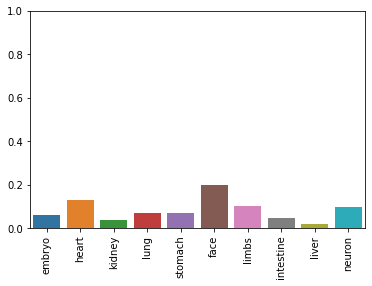


20211212_122659__199840__160::fsp__sknsh__0  |  K562 l2FC = -0.37,  HepG2 l2FC = 0.4,  SKNSH l2FC = 4.06  | (Topic 8 OverMax = 25076.29)


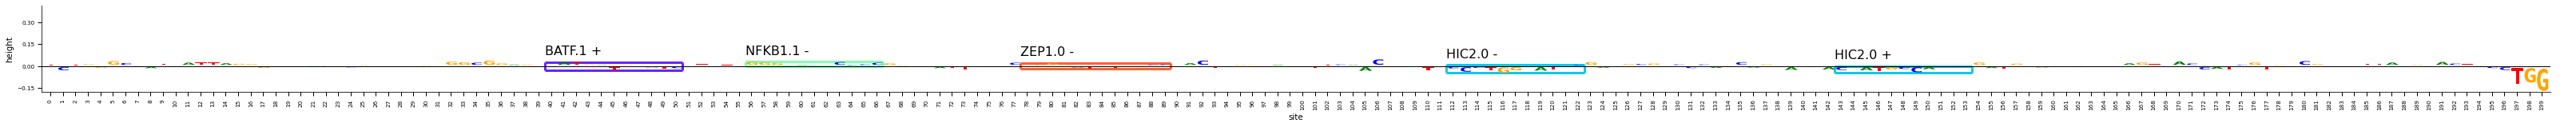

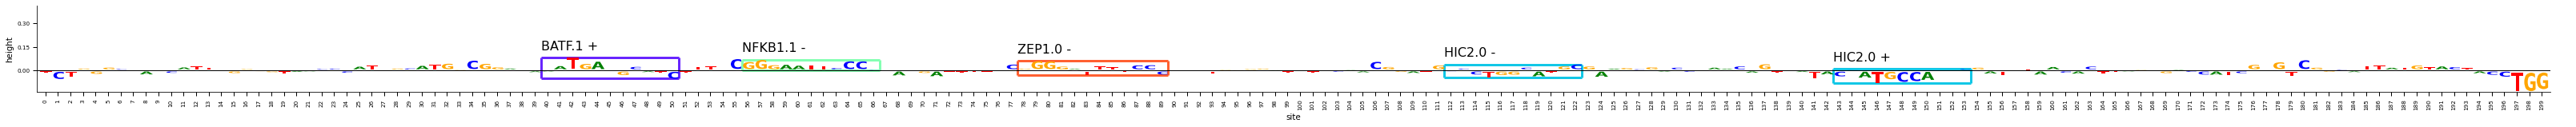

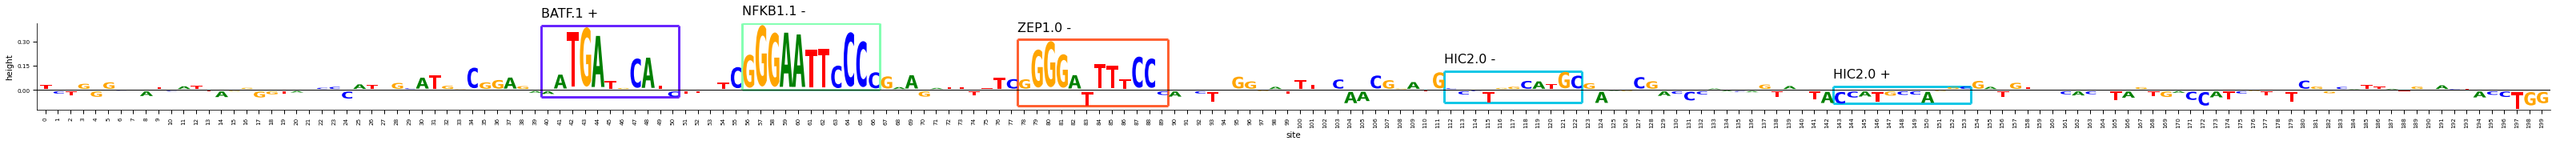

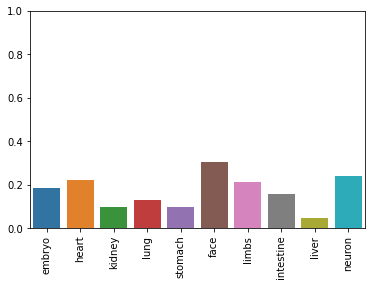


20211212_14909__942569__1781::fsp__sknsh__0  |  K562 l2FC = -0.71,  HepG2 l2FC = 0.6,  SKNSH l2FC = 4.92  | (Topic 8 OverMax = 39192.43)


KeyboardInterrupt: ignored

In [ ]:
topic_idx = 8
num_seqs_to_display = 10
seq_idxs = np.where(over_means[:, topic_idx] > 0)[0]
seq_ids = temp_df.iloc[seq_idxs]['ID'].tolist()
topic_overmaxs = over_means[seq_idxs, topic_idx]
idxs_to_display = np.flip(np.argsort(topic_overmaxs))[:num_seqs_to_display]
seq_ids = [seq_ids[i] for i in idxs_to_display]

intersection_threshold = 3
cmap = plt.cm.get_cmap('rainbow', len(motif_list)) 

color_dict = dict(zip(2*motif_list, 2*[cmap(i) for i in range(len(motif_list))]))

#for order_idx, seq_id in enumerate(seq_ids):
for order_idx, seq_id in zip(idxs_to_display, seq_ids):
    seq_df = seq_merge_df[seq_merge_df['ID'] == seq_id]
    seq_idx = seq_df.index.item()

    k562_lfc = np.round(seq_df['K562_signal'].item(), 2)
    hepg2_lfc = np.round(seq_df['HepG2_signal'].item(), 2)
    sknsh_lfc = np.round(seq_df['SKNSH_signal'].item(), 2)

    main_topic = seq_df['hot_topic'].item()
    topic_overmax = np.round(seq_df['topic_OverMax'].item(), 2)
    # hot_topics[order_idx]
    # topic_overmax = np.round(topic_overmaxs[order_idx], 2)
    print(f'{seq_id}  |  K562 l2FC = {k562_lfc},  HepG2 l2FC = {hepg2_lfc},  SKNSH l2FC = {sknsh_lfc}  | (Topic {main_topic} OverMax = {topic_overmax})')

    seq_scan_df = fimo_df[fimo_df['sequence_name'] == seq_id]
    seq_scan_df = seq_scan_df.sort_values('p-value', ascending=True).reset_index(drop=False)

    seq_contributions = contribution_tensor[:, seq_idx, ...]
    y_max = seq_contributions.max()

    
    find_motif_names  = []
    motifs_start_ends = []
    orientations      = []
    cover_set         = set()
    num_hits = len(seq_scan_df)
    for i in range(num_hits):
        hit_row = seq_scan_df.iloc[i]
        m_start, m_end = hit_row['start'], hit_row['stop']
        motif_range = set(np.arange(m_start, m_end))
        motif_contributions = seq_contributions[..., m_start:m_end].sum(dim=1).mean(dim=-1)
        pos_contribution = motif_contributions.max()
        neg_contribution = motif_contributions.min()
        contribution_condition = (pos_contribution > 0.06) or (neg_contribution < -0.02)
        if (len(cover_set & motif_range) <= intersection_threshold) and contribution_condition:
            find_motif_names.append(hit_row['motif_id'])
            motifs_start_ends.append((m_start, m_end))
            orientations.append(hit_row['strand'])
            cover_set = cover_set | motif_range
    find_motif_short_names = [name.split('_')[0] + '.' + name.split('_')[1].split('.')[2] + ' ' + strand for name, strand in zip(find_motif_names, orientations)]

    for i in range(0,3):
        matrix_plot = seq_contributions[i, ...]
        contrib_min_maxs = [(matrix_plot[:, m_start:m_end].min().item(), matrix_plot[:, m_start:m_end].max().item()) \
                            for m_start, m_end in motifs_start_ends]
        fig, ax = matrix_to_dms(matrix_plot, y_max=y_max, colors=['green','blue','orange','red'], \
                            heightscale=0.8, fontaspect=0.55)
        for idx, motif_name in enumerate(find_motif_names):
            color = color_dict[motif_name]
            plt.vlines(motifs_start_ends[idx][0], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.vlines(motifs_start_ends[idx][1], contrib_min_maxs[idx][0], contrib_min_maxs[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][0], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)
            plt.hlines(contrib_min_maxs[idx][1], motifs_start_ends[idx][0], motifs_start_ends[idx][1], linestyles='solid', colors=color, linewidth=3.0)

            text = f'{find_motif_short_names[idx]}'#' ({motif_pct_select[idx]}%)'
            x = motifs_start_ends[idx][0] 
            y = contrib_min_maxs[idx][1] + 0.05  
            plt.text(x, y, text, fontsize=16)  
        plt.show()  

    sns.barplot(data=pd.DataFrame(seq_df[enformer_scores_df_2.columns[1:]])).set(ylim=(0,1))
    plt.xticks(rotation=90)
    plt.show()

    print('')